In [1]:
import spacy 
import re 
import pandas as pd
from spacy.lang.en import English
from collections import Counter
from itertools import chain
import ahocorasick
import ast
from analyze_m_data import get_occupations_list_en, get_occupations_list
from spacy.lang.de import German
from spacy.lang.it import Italian
from spacy.lang.es import Spanish 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from operator import itemgetter

In [2]:
def stem_titles(titles):
  from nltk.stem import SnowballStemmer 
  stemmer = SnowballStemmer("italian") # Choose a language
  stems = []
  for title in titles:
     stem = stemmer.stem(title)
     stems.append(stem)
  return stems
it_occ_titles = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/it_occ_list_from_en.csv', encoding='utf-8')
it_occ_list = it_occ_titles['occupations'].to_list()
stems = stem_titles(it_occ_list)
print(stems[:10])

['astrazion', 'contabil', 'acrob', 'attor', 'attric', 'attuar', 'agopressor', 'agopuntur', 'indirizz', 'giudice arbitr']


In [6]:
def get_occupations(df):
    new_df = df
    # print(unique_gender_counts)
    # number of biographies that returned no intro 
    print("num intros unavailable")
    print((new_df['intro'] == 'No intro available').sum())
    # remove biographies with no intro 
    new_df = new_df[new_df.intro != 'No intro available']
    print(new_df.shape[0])
    small_df = new_df.copy()
    # lowercase intro strings
    small_df['intro'] = small_df['intro'].str.casefold()
    small_df['title'] = small_df['title'].str.casefold()
    # small_df = small_df[small_df['gender'] == 'female']
    # small_df['first_sentence'] = small_df['first_sentence'].str.casefold()
    # the lists in the occupations column were not actual lists but rather string literals
    # this code converts them back into lists  
    # small_df['occupations'] = small_df['occupations'].apply(ast.literal_eval)

    # get a set of occupation words 
    full_unique_occupations = set(stem_titles(it_occ_list))
    # full_unique_occupations = set(stem_titles(es_occ_list))
    # full_unique_occupations = get_occupations_list('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/de_occ_titles.csv', gender)
    # full_unique_occupations = get_occupations_list_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/it_occ_list_full.csv')
    # full_unique_occupations = get_occupations_list_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/es_occ_list_unique.csv')
    small_df['intro'] = small_df['intro'].astype(str)
    small_df['title'] = small_df['title'].astype(str)
    
    print(small_df.dtypes)
    # want to find overlapping terms in the intros column and the wikidata occupation words set 
    automaton = ahocorasick.Automaton()
    for id, term in enumerate(full_unique_occupations):
        automaton.add_word(term, (term))
    automaton.remove_word('-')
    automaton.make_automaton()
    def find_terms_en(text):
        return list(term for _, term in automaton.iter(text))
    def find_terms_de(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches
    def find_terms_stems1(text):
      matching_tokens = []
      substrings = list(full_unique_occupations)
      tokens = text.split()
      for token in tokens:
        if any(sub in token for sub in substrings):
          matching_tokens.append(token)
      return matching_tokens
    
    def find_terms_stems(text):
      # ner = spacy.load('en_core_web_sm') 
      # ner = spacy.load('de_core_news_sm')
      ner = spacy.load('it_core_news_sm') 
      # ner = spacy.load('es_core_news_sm')
      doc = ner(text) 
      occupational_titles = list(full_unique_occupations)
      matched_occupations = []
      for ent in doc: 
        if any(sub in ent.text.casefold() for sub in occupational_titles):
          if not ent.ent_type_:
              # matched_occupations.append(ent.text)
              matched_occupations.append({ent.text: ent.morph.get("Gender")})
        # print(ent.text, ent.pos_, ent.dep_)
          # print(ent,ent.morph.get("Gender"))
      return (matched_occupations)
    
    # small_df['overlapping_occupations'] = small_df['intro'].apply(find_terms_stems)
    # small_df['overlapping_occupations_sentence1'] = small_df['first_sentence'].apply(find_terms_stems)
    # want to see if male occupation names show up in title field as last names 
    # small_df['occupation_in_last_name'] = small_df['title'].apply(find_terms_stems)
    small_df['overlapping_occupations_sentence1'] = small_df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    occ_counts_counter = Counter(
    key
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for key in d.keys()
    )

    occ_gender_counts_counter = Counter(
    value
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for values in d.values()
    for value in values
    )
   
    # overlapping_occ_counts = Counter(chain.from_iterable([small_df['overlapping_occupations_sentence1'].keys()]))
    # print(small_df[['wikidata_code','intro', 'overlapping_occupations']].head(20))
    print(occ_counts_counter)
    print(occ_gender_counts_counter)
    smaller_df = small_df[small_df['overlapping_occupations_sentence1'].map(len)>0]
    # smaller_df = smaller_df[smaller_df['overlapping_occupations'].map(len)>0]

    print("length of dataset:")
    print(small_df.shape[0])
    print("first sentences with occ title found:", smaller_df.shape[0])
    return occ_counts_counter

In [5]:
it_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/it/it_female_occ_all.csv', encoding='utf-8')
female_occ_counts = get_occupations(it_female_df)

num intros unavailable
0
7852
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'attrice': 1417, 'cestista': 921, 'maggio': 743, 'politica': 681, 'scrittrice': 621, 'calciatrice': 536, 'cantante': 451, 'giornalista': 444, 'conduttrice': 423, 'per': 283, 'modella': 250, 'doppiatrice': 248, 'poetessa': 177, 'direttrice': 111, 'allenatrice': 110, 'nobildonna': 107, 'storica': 105, 'ballerina': 99, 'saggista': 90, 'personaggio': 74, 'doppiaggio': 72, 'canadese': 70, 'deputata': 68, 'critica': 68, 'artista': 60, 'argentina': 57, 'insegnante': 54, 'portiere': 45, 'figlia': 42, 'musicist

In [6]:
it_female_df2 = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/it/it_female_occ_2.csv', encoding='utf-8')
female_occ_counts2 = get_occupations(it_female_df2)

num intros unavailable
0
7852
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'attrice': 1417, 'cestista': 921, 'politica': 681, 'scrittrice': 621, 'calciatrice': 536, 'cantante': 451, 'giornalista': 444, 'conduttrice': 423, 'per': 283, 'modella': 250, 'doppiatrice': 248, 'poetessa': 177, 'traduttrice': 133, 'schermitrice': 125, 'direttrice': 111, 'allenatrice': 110, 'nobildonna': 107, 'autrice': 107, 'storica': 105, 'ballerina': 99, 'vincitrice': 97, 'saggista': 90, 'cantautrice': 89, 'pittrice': 87, 'sceneggiatrice': 77, 'giocatrice': 75, 'personaggio': 74, 'doppiaggio': 72, '

In [36]:
it_female_df2 = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/it/it_female_occ_2.csv', encoding='utf-8')
female_occ_counts2 = get_occupations(it_female_df2)

num intros unavailable
0
7852
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'attrice': 1417, 'cestista': 921, 'politica': 681, 'scrittrice': 621, 'calciatrice': 536, 'cantante': 451, 'giornalista': 443, 'conduttrice': 423, 'per': 283, 'modella': 250, 'doppiatrice': 248, 'poetessa': 177, 'traduttrice': 133, 'schermitrice': 125, 'direttrice': 111, 'allenatrice': 110, 'nobildonna': 107, 'autrice': 107, 'storica': 105, 'ballerina': 99, 'vincitrice': 97, 'saggista': 90, 'cantautrice': 89, 'pittrice': 87, 'sceneggiatrice': 77, 'giocatrice': 75, 'personaggio': 74, 'doppiaggio': 72, '

In [19]:
it_male_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/it/it_male_occ_all.csv', encoding='utf-8')
get_occupations(it_male_df)

num intros unavailable
0
7784
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'politico': 1213, 'calciatore': 1179, 'maggio': 798, 'scrittore': 423, 'allenatore': 398, 'giornalista': 379, 'attore': 332, 'pittore': 266, 'cestista': 231, 'per': 195, 'poeta': 189, 'storico': 186, 'avvocato': 174, 'compositore': 163, 'architetto': 146, 'sportivo': 139, 'critico': 123, 'direttore': 120, 'scultore': 118, 'portiere': 113, 'medico': 112, 'saggista': 95, 'produttore': 87, 'conduttore': 85, 'cantante': 77, 'seconda': 76, 'musicista': 74, 'autore': 71, 'cantautore': 71, 'presidente': 68, '

In [7]:
it_male_df2 = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/it/it_male_occ_2.csv', encoding='utf-8')
male_occ_counts2 = get_occupations(it_male_df2)

num intros unavailable
0
7784
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'politico': 1213, 'calciatore': 1179, 'scrittore': 423, 'allenatore': 398, 'giornalista': 379, 'attore': 332, 'pittore': 266, 'cestista': 231, 'per': 195, 'poeta': 189, 'storico': 186, 'imprenditore': 177, 'avvocato': 174, 'compositore': 163, 'giocatore': 154, 'architetto': 146, 'sportivo': 139, 'critico': 123, 'direttore': 120, 'scultore': 118, 'portiere': 113, 'medico': 112, 'saggista': 95, 'produttore': 87, 'conduttore': 85, 'cantante': 77, 'seconda': 76, 'musicista': 74, 'autore': 71, 'aviatore': 7

In [8]:
it_other_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/redo/it_other_occ.csv', encoding='utf-8')
other_occ_counts = get_occupations(it_other_df)

num intros unavailable
0
82
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'attrice': 35, 'cantante': 10, 'modella': 8, 'attore': 7, 'politica': 4, 'scrittrice': 4, 'film': 3, 'precedentemente': 3, 'vincitrice': 3, 'donna': 3, 'produttrice': 3, 'musicista': 3, 'artista': 2, 'politicamente': 2, 'ballerina': 2, 'conduttrice': 2, 'compositore': 2, 'interprete': 1, 'seconda': 1, 'chirurgico': 1, 'compositrice': 1, 'produttore': 1, 'chirurga': 1, 'ministra': 1, 'programmatrice': 1, 'cantautore': 1, 'filippina': 1, 'senatrice': 1, 'ragazza': 1, 'internazionale': 1, 'fotografa': 1, 'm

In [21]:
def get_occ_gender_counts(df):
    result = {}
    df['overlapping_occupations_sentence1'] = df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    # Define the expected gender categories
    genders = ['Fem', 'Masc', 'Neutral']
    occupation_list = df['overlapping_occupations_sentence1'].tolist()
    # Loop through each item in the list
    for items in occupation_list :
        for item in items:
            for profession, gender_list in item.items():
                # Ensure the profession is in the result dictionary
                if profession not in result:
                    result[profession] = {g: 0 for g in genders}

                if not gender_list:
                    result[profession]['Neutral'] += 1
                else:
                    # Increment the corresponding gender count
                    for gender in gender_list:
                        if gender in result[profession]:
                            result[profession][gender] += 1
    # print(result)
    return result

In [22]:
it_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/it/it_female_occ_all.csv', encoding='utf-8')


In [23]:
occupation_genders = get_occ_gender_counts(it_female_df)

In [25]:
print(occupation_genders['medico'])
print(occupation_genders['presidente'])


{'Fem': 0, 'Masc': 28, 'Neutral': 0}
{'Fem': 0, 'Masc': 25, 'Neutral': 0}


In [44]:
occupation_genders.pop('doppiaggio')
occupation_genders.pop('maggio')
occupation_genders.pop('campionati')
occupation_genders.pop('argento')
occupation_genders.pop('ragazzi')
occupation_genders.pop('musical')
occupation_genders.pop('secondo')


KeyError: 'doppiaggio'

In [ ]:
occupation_genders.pop('governo')
occupation_genders.pop('interpretato')
occupation_genders.pop('rappresentato')
occupation_genders.pop('letterario')
occupation_genders.pop('campionato')
occupation_genders.pop('programma')
occupation_genders.pop('rapporti')
occupation_genders.pop('governi')



{'Fem': 0, 'Masc': 4, 'Neutral': 0}

In [51]:
print(occupation_genders['medica'])

{'Fem': 5, 'Masc': 0, 'Neutral': 0}


In [49]:
summary_df = pd.DataFrame(occupation_genders).T.fillna(0).astype(int)

In [50]:
# Step 1: Add a total column
summary_df['Total'] = summary_df.sum(axis=1)

# Step 2: Calculate male percentage
summary_df['Male_Percentage'] = summary_df['Masc'] / summary_df['Total']

# Step 3: Sort by male percentage (descending)
sorted_by_male = summary_df.sort_values(by='Masc', ascending=False)


print(sorted_by_male[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

                 Fem  Masc  Total  Male_Percentage
cestista         213   315    921         0.342020
personaggio        0    74     74         1.000000
portiere           0    45     45         1.000000
medico             0    28     28         1.000000
presidente         0    25     25         1.000000
tecnico            0    16     16         1.000000
blogger            0    13     21         0.619048
attore             0    11     11         1.000000
capitano           0    10     13         0.769231
sindaco            0    10     10         1.000000
calciatrice      491    10    536         0.018657
musicista         25     9     42         0.214286
avvocato           0     8      8         1.000000
architetto         0     8      8         1.000000
sportivo           0     7      7         1.000000
sottosegretario    0     6      6         1.000000
giudice            0     5      5         1.000000
allenatore         0     5      5         1.000000
arbitro            0     5     

In [19]:
it_male_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/it/it_male_occ_all.csv', encoding='utf-8')


In [20]:
get_occ_gender_counts(it_male_df)

{'ceramista': {'Fem': 0, 'Masc': 1, 'Neutral': 10}, 'compositore': {'Fem': 0, 'Masc': 163, 'Neutral': 0}, 'direttore': {'Fem': 0, 'Masc': 120, 'Neutral': 0}, 'coreografo': {'Fem': 0, 'Masc': 7, 'Neutral': 0}, 'pittore': {'Fem': 0, 'Masc': 266, 'Neutral': 0}, 'produttore': {'Fem': 0, 'Masc': 87, 'Neutral': 0}, 'politico': {'Fem': 0, 'Masc': 1213, 'Neutral': 0}, 'presidente': {'Fem': 0, 'Masc': 68, 'Neutral': 0}, 'amministratore': {'Fem': 0, 'Masc': 5, 'Neutral': 0}, 'artista': {'Fem': 0, 'Masc': 0, 'Neutral': 55}, 'storico': {'Fem': 0, 'Masc': 186, 'Neutral': 0}, 'impiegato': {'Fem': 0, 'Masc': 1, 'Neutral': 0}, 'cantante': {'Fem': 0, 'Masc': 0, 'Neutral': 77}, 'allenatore': {'Fem': 0, 'Masc': 398, 'Neutral': 0}, 'calciatore': {'Fem': 0, 'Masc': 1133, 'Neutral': 46}, 'ingegnere': {'Fem': 0, 'Masc': 55, 'Neutral': 0}, 'ricercatore': {'Fem': 0, 'Masc': 9, 'Neutral': 0}, 'per': {'Fem': 0, 'Masc': 0, 'Neutral': 195}, 'principale': {'Fem': 0, 'Masc': 0, 'Neutral': 4}, 'programma': {'Fem': 0,

In [24]:
def make_plot(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:31])
    ten_items.pop('trayectoria', None)
    ten_items.pop('per', None)
    ten_items.pop('canadese', None)
    ten_items.pop('doppiaggio', None)
    ten_items.pop('argentina', None)
    print(ten_items)
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), averages, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Percentage of Occupational Title Occurences in Italian Male Data")
    plt.show()

{'attrice': 1417, 'cestista': 921, 'politica': 681, 'scrittrice': 621, 'calciatrice': 536, 'cantante': 451, 'giornalista': 444, 'conduttrice': 423, 'modella': 250, 'doppiatrice': 248, 'poetessa': 177, 'traduttrice': 133, 'schermitrice': 125, 'direttrice': 111, 'allenatrice': 110, 'nobildonna': 107, 'autrice': 107, 'storica': 105, 'ballerina': 99, 'vincitrice': 97, 'saggista': 90, 'cantautrice': 89, 'pittrice': 87, 'sceneggiatrice': 77, 'giocatrice': 75, 'personaggio': 74, 'deputata': 68, 'critica': 68, 'artista': 60, 'insegnante': 54}
7905.0
[0.17925363693864643, 0.11650853889943075, 0.08614800759013283, 0.07855787476280834, 0.06780518659076534, 0.05705249841872233, 0.05616698292220114, 0.05351043643263757, 0.031625553447185324, 0.03137254901960784]


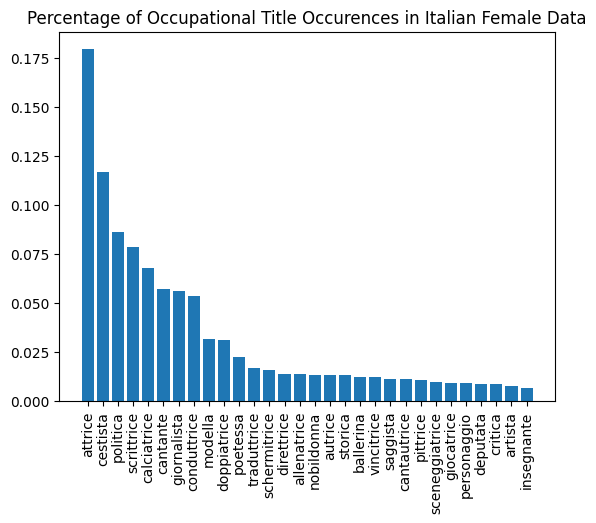

In [21]:
make_plot(female_occ_counts2)

{'politico': 1213, 'calciatore': 1179, 'scrittore': 423, 'allenatore': 398, 'giornalista': 379, 'attore': 332, 'pittore': 266, 'cestista': 231, 'poeta': 189, 'storico': 186, 'imprenditore': 177, 'avvocato': 174, 'compositore': 163, 'giocatore': 154, 'architetto': 146, 'sportivo': 139, 'critico': 123, 'direttore': 120, 'scultore': 118, 'portiere': 113, 'medico': 112, 'saggista': 95, 'produttore': 87, 'conduttore': 85, 'cantante': 77, 'seconda': 76, 'musicista': 74, 'autore': 71, 'aviatore': 71, 'cantautore': 71}
7042.0
[0.17225220107923886, 0.16742402726498154, 0.060068162453848335, 0.05651803464924737, 0.05381993751775064, 0.04714569724510082, 0.03777335984095427, 0.032803180914512925, 0.0268389662027833, 0.026412950866231185]


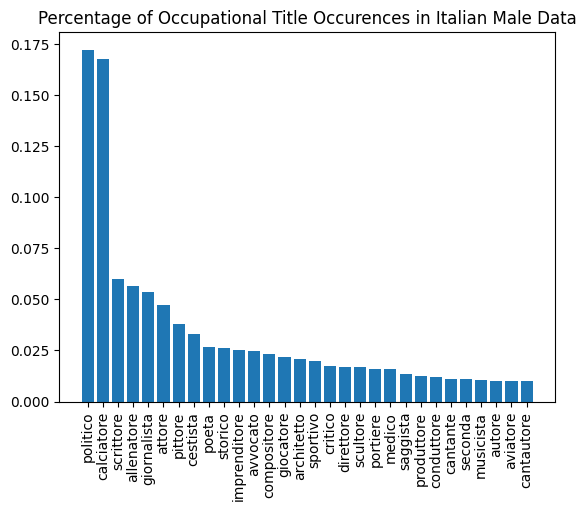

In [25]:
make_plot(male_occ_counts2)

In [37]:
female_occ_dict = dict(sorted(female_occ_counts2.items(), key=itemgetter(1), reverse=True))
professions_it = ["medico","medica","capitano","capitana","sindaco","sindaca","avvocato",'avvocata',"architetto","architetta","sportivo","sportiva","sottosegretario",
"sottosegretaria","allenatore","allenatrice","critico","critica","magistrato","magistrata","deputato","deputata","ministro","ministra","senatore","senatrice","dottore","dottoressa","assessore","assessora",
"carabiniere","carabiniera","deputato","deputata","direttore","direttrice"]

In [38]:
def filter_dict(pair):
    key,value = pair
    if key in professions_it:
        return True
    else:
        return False

filtered_professions = dict(filter(filter_dict, female_occ_dict.items()))
print(filtered_professions)

{'direttrice': 111, 'allenatrice': 110, 'deputata': 68, 'critica': 68, 'senatrice': 39, 'sportiva': 32, 'medico': 28, 'capitano': 13, 'sindaco': 10, 'sindaca': 10, 'architetto': 8, 'avvocato': 8, 'avvocata': 7, 'architetta': 7, 'sportivo': 7, 'sottosegretario': 6, 'sottosegretaria': 6, 'medica': 5, 'critico': 5, 'allenatore': 4, 'deputato': 4, 'magistrato': 3, 'magistrata': 3, 'senatore': 2, 'direttore': 2}


In [33]:
def make_plot2(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = overlapping_occ_counts
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), values, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Occurrences of Occupational Title Occurences in Italian Female Data")

566.0
[0.196113074204947, 0.19434628975265017, 0.12014134275618374, 0.12014134275618374, 0.06890459363957598, 0.05653710247349823, 0.04946996466431095, 0.022968197879858657, 0.0176678445229682, 0.0176678445229682]


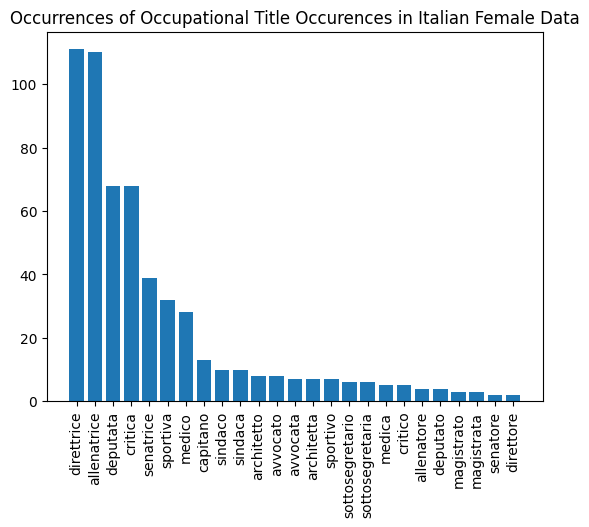

In [39]:
make_plot2(filtered_professions)